In [18]:
from data_utils import *
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import glob
from feature_utils import get_sobel_features, get_gabor_features, generate_gabor_kernel, get_local_binary_pattern
from skimage.transform import resize

In [7]:
def get_images(data_dir, disaster, label):
    """
    Load images from a specified disaster dataset split.

    Args:
        data_dir (str): The directory where the dataset is stored.
        disaster (str): The disaster type of the dataset.

    Returns:
        list: A list of images (as numpy arrays) from the specified dataset split.
    """
    images_path = os.path.join(data_dir, disaster, f"{label}_images.npz")
    return load_images(images_path)


def get_labels(data_dir, disaster, label):
    """
    Load labels for a specified disaster dataset split.

    Args:
        data_dir (str): The directory where the dataset is stored.
        disaster (str): The disaster type of the dataset.

    Returns:
        ndarray: The labels for the images in the specified dataset split.
    """
    labels_path = os.path.join(data_dir, disaster, f"{label}_labels.npy")
    return load_labels(labels_path)

In [47]:
disaster_list = ["hurricane-matthew", "socal-fire", "midwest-flooding"]

disaster_mapping = {name: idx for idx, name in enumerate(disaster_list)}


images = []
labels = []
disaster_types = []

label = "train"
with open('config.json') as config_file:
    config = json.load(config_file)
    data_dir = config['data_dir']

for disaster in disaster_list:
    print(f"Loading {label} images and labels for {disaster} dataset...")
    img = get_images(data_dir, disaster, label)
    lbl = get_labels(data_dir, disaster, label)

    # Resize images
    resized_image = [resize(i, (64, 64), anti_aliasing=True) for i in img]

    images.extend(resized_image)
    labels.extend(lbl)
    disaster_types.extend([disaster_mapping[disaster]] * len(lbl))

x_dataset = {
    "images" : np.asarray(images),
}

y_dataset = {
    "label_and_disastertype": np.column_stack((labels, disaster_types))
}

Loading train images and labels for hurricane-matthew dataset...
Loading train images and labels for socal-fire dataset...
Loading train images and labels for midwest-flooding dataset...


In [48]:
x_dataset

{'images': array([[[[0.22847111, 0.36998219, 0.32687557],
          [0.23367369, 0.3778598 , 0.33475318],
          [0.23770632, 0.38280436, 0.33730804],
          ...,
          [0.24120136, 0.3690626 , 0.3683632 ],
          [0.20989966, 0.33630898, 0.3284893 ],
          [0.21512331, 0.34422871, 0.33638796]],
 
         [[0.27900056, 0.42392195, 0.384791  ],
          [0.26082309, 0.40580767, 0.36661353],
          [0.24040001, 0.38540614, 0.34385675],
          ...,
          [0.22867551, 0.3541456 , 0.35018813],
          [0.2372707 , 0.36375038, 0.35881778],
          [0.22141018, 0.35052275, 0.34289407]],
 
         [[0.22897088, 0.36639093, 0.33094363],
          [0.23964987, 0.37987132, 0.34172794],
          [0.23410501, 0.37528148, 0.33612563],
          ...,
          [0.22362276, 0.34819527, 0.34264849],
          [0.2226821 , 0.35194068, 0.34317842],
          [0.22019665, 0.34945523, 0.3379969 ]],
 
         ...,
 
         [[0.24437423, 0.38046348, 0.40268603],
        

In [49]:
y_dataset

{'label_and_disastertype': array([[3, 0],
        [0, 0],
        [1, 0],
        ...,
        [0, 2],
        [0, 2],
        [0, 2]])}

## Disaster Type CNN

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from skimage.transform import resize

In [65]:
damage_labels = y_dataset["label_and_disastertype"][:, 0]
disaster_labels = y_dataset["label_and_disastertype"][:, 1]

# train test split with 0.2 split
X_train, X_test, y_damage_train, y_damage_test, y_disaster_train, y_disaster_test = train_test_split(
    x_dataset["images"],
    damage_labels,
    disaster_labels,
    test_size=0.2,
    random_state=42,
)

In [78]:
print(np.unique(damage_labels))

[0 1 2 3]


In [79]:
num_disaster_classes = 3
num_damage_classes = 4

# Input
inp = Input(shape=(64, 64, 3))

# Shared CNN feature extractor
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inp)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalMaxPooling2D()(x)

# Fully connected shared layer
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

In [80]:
# for disaster type prediction
disaster_output = layers.Dense(num_disaster_classes, activation='softmax', name='disaster_output')(x)

In [81]:
# Output 2: damage label output
damage_label_output = layers.Dense(num_damage_classes, activation='softmax', name='damage_output')(x)

In [82]:
# Build model
model = Model(inputs=inp, outputs=[disaster_output, damage_label_output])
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={'disaster_output': 'sparse_categorical_crossentropy',
          'damage_output': 'sparse_categorical_crossentropy'},
    metrics={'disaster_output': 'accuracy',
             'damage_output': 'accuracy'}
)
model.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │        896 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disaster_output     │ (None, 3)         │        387 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ damage_output       │ (None, 4)         │        516 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,559 (435.78 KB)

 Trainable params: 111,111 (434.03 KB)

 Non-trainable params: 448 (1.75 KB)

In [88]:
# fit the model
history = model.fit(
    X_train,
    {'damage_output': y_damage_train, 'disaster_output': y_disaster_train},
    validation_data=(X_test, {'damage_output': y_damage_test, 'disaster_output': y_disaster_test}),
    epochs=100,
    batch_size=50,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/100
425/425 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - damage_output_accuracy: 0.7835 - damage_output_loss: 0.5464 - disaster_output_accuracy: 0.9743 - disaster_output_loss: 0.0784 - loss: 0.6248 - val_damage_output_accuracy: 0.7944 - val_damage_output_loss: 0.5442 - val_disaster_output_accuracy: 0.9668 - val_disaster_output_loss: 0.0934 - val_loss: 0.6403
Epoch 2/100
425/425 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - damage_output_accuracy: 0.7925 - damage_output_loss: 0.5236 - disaster_output_accuracy: 0.9818 - disaster_output_loss: 0.0532 - loss: 0.5768 - val_damage_output_accuracy: 0.7963 - val_damage_output_loss: 0.5203 - val_disaster_output_accuracy: 0.9781 - val_disaster_output_loss: 0.0625 - val_loss: 0.5856
Epoch 3/100
425/425 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - damage_output_accuracy: 0.7998 - damage_output_loss: 0.5016 - disaster_output_accuracy: 0.9809 - disaster_output_loss: 0.0538 - loss: 0.5554 - val_damage_output_accuracy: 0.7716 - val_damage_output_loss: 0.5677 - val_disa

In [89]:
model.evaluate(
    X_test, 
    {'damage_output': y_damage_test, 'disaster_output': y_disaster_test}, 
    verbose=2)

166/166 - 1s - 9ms/step - damage_output_accuracy: 0.7980 - damage_output_loss: 0.5104 - disaster_output_accuracy: 0.9785 - disaster_output_loss: 0.0677 - loss: 0.5783


[0.5783219337463379,
 0.06769506633281708,
 0.510383665561676,
 0.7980026602745056,
 0.9785189628601074]

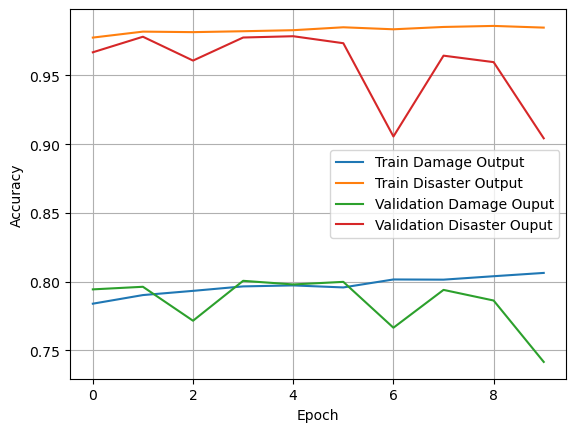

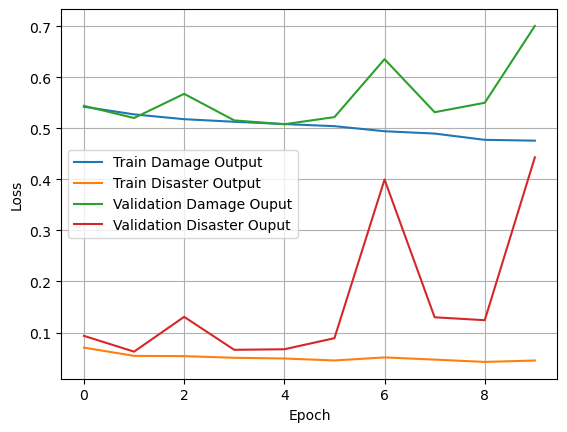

In [90]:
# plot accuracy
plt.plot(history.history['damage_output_accuracy'], label='Train Damage Output')
plt.plot(history.history['disaster_output_accuracy'], label='Train Disaster Output')
plt.plot(history.history['val_damage_output_accuracy'], label='Validation Damage Ouput')
plt.plot(history.history['val_disaster_output_accuracy'], label='Validation Disaster Ouput')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.grid(True)
plt.show()

# plot loss
plt.plot(history.history['damage_output_loss'], label='Train Damage Output')
plt.plot(history.history['disaster_output_loss'], label='Train Disaster Output')
plt.plot(history.history['val_damage_output_loss'], label='Validation Damage Ouput')
plt.plot(history.history['val_disaster_output_loss'], label='Validation Disaster Ouput')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()